# Learning Jammers: Loss Simulations
In this notebook, we will simulate different losses, compare their performance (BER) and have a look at their learned weights.

### Evaluation of different Losses

In [6]:
import os
# import drjit
gpu_num = 5 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [7]:
# common parameters
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = 1.0
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["trainable"] = True
model_parameters["jammer_parameters"] = jammer_parameters

Here the simulation with NonNegMaxMeanSquareNorm as integrated constraint as a reference.

In [9]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
jammer_parameters["trainable"] = False
# None = all weights are trainable
jammer_parameters["trainable_mask"] = None
snrs = np.arange(-5, 10.5, 2.5, dtype=np.float32)
for ebno_db in snrs:
    jammer_parameters["training_constraint"] = NonNegMaxMeanSquareNorm(1.0)
    jammer_parameters["constraint_integrated"] = True
    filename = f"weights/{ebno_db}db.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{ebno_db}db")
ber_plots.title = "NonNegative, integrated"

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.3695e-01 | 1.0000e+00 |     1863223 |     5529600 |         2400 |        2400 |        17.5 |reached max iter       
   -3.571 | 3.3324e-01 | 1.0000e+00 |     1842698 |     5529600 |         2400 |        2400 |        11.7 |reached max iter       
   -2.143 | 3.3003e-01 | 1.0000e+00 |     1824908 |     5529600 |         2400 |        2400 |        11.5 |reached max iter       
   -0.714 | 3.2859e-01 | 1.0000e+00 |     1816951 |     5529600 |         2400 |        2400 |        11.5 |reached max iter       
    0.714 | 3.2726e-01 | 1.0000e+00 |     1809641 |     5529600 |         2400 |        2400 |        11.6 |reached max iter       
    2.143 | 3.2638e-01 | 1.0000e+00 |     1804747 |     5529600 |         2400 |     

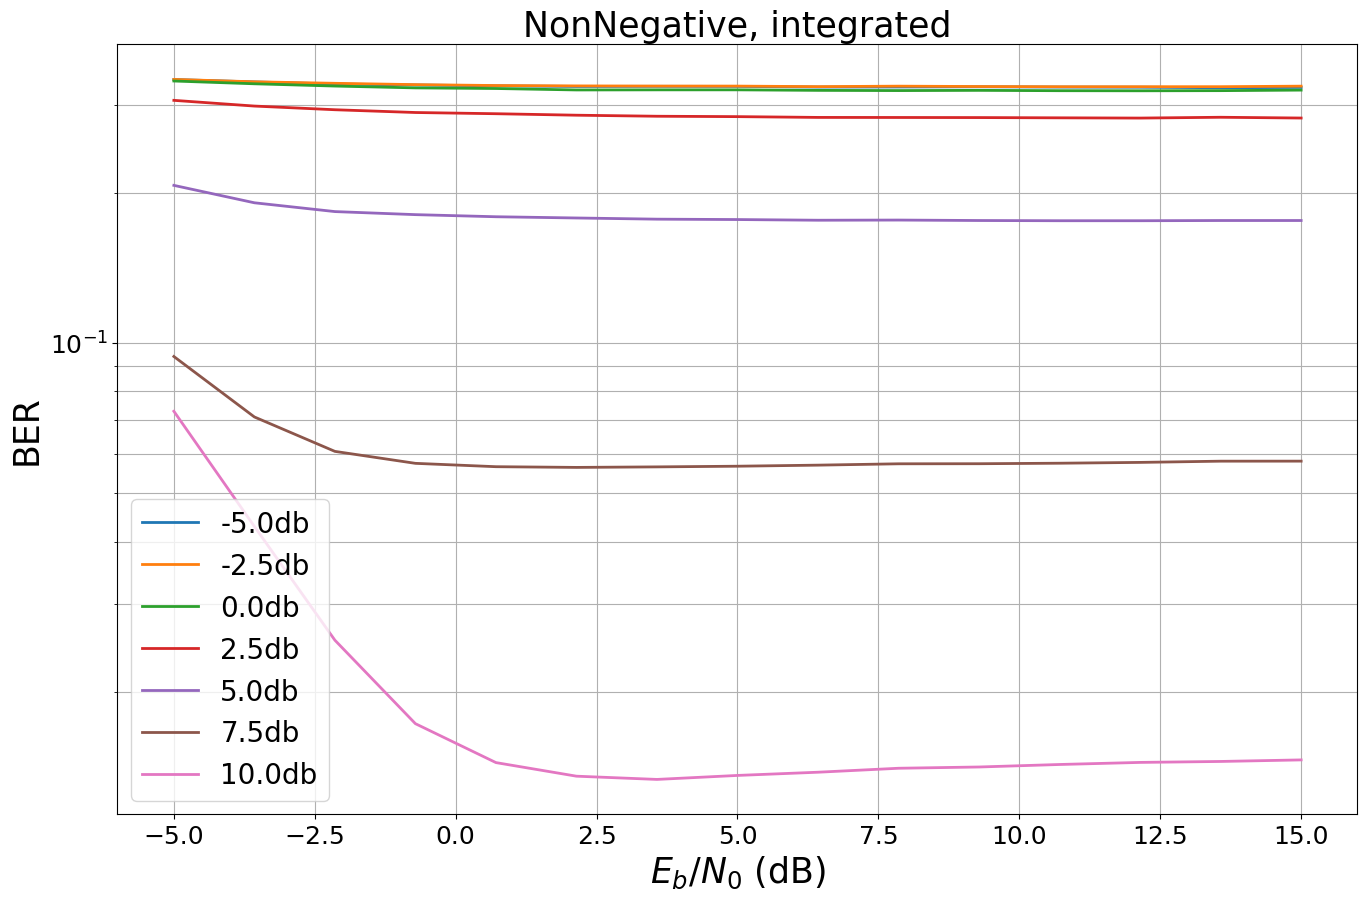

In [13]:
ber_plots()

### Problem Fixing

We tried to improve this by "fixing" the dying ReLU problem. Below is the same training, but using MaxMeanSquareNorm instead of NonNegMaxMeanSquareNorm.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.3846e-01 | 1.0000e+00 |     1871537 |     5529600 |         2400 |        2400 |        17.3 |reached max iter       
   -3.571 | 3.3462e-01 | 1.0000e+00 |     1850297 |     5529600 |         2400 |        2400 |        11.5 |reached max iter       
   -2.143 | 3.3149e-01 | 1.0000e+00 |     1832998 |     5529600 |         2400 |        2400 |        11.4 |reached max iter       
   -0.714 | 3.2958e-01 | 1.0000e+00 |     1822458 |     5529600 |         2400 |        2400 |        11.5 |reached max iter       
    0.714 | 3.2777e-01 | 1.0000e+00 |     1812455 |     5529600 |         2400 |        2400 |        11.5 |reached max iter       
    2.143 | 3.2667e-01 | 1.0000e+00 |     1806381 |     5529600 |         2400 |     

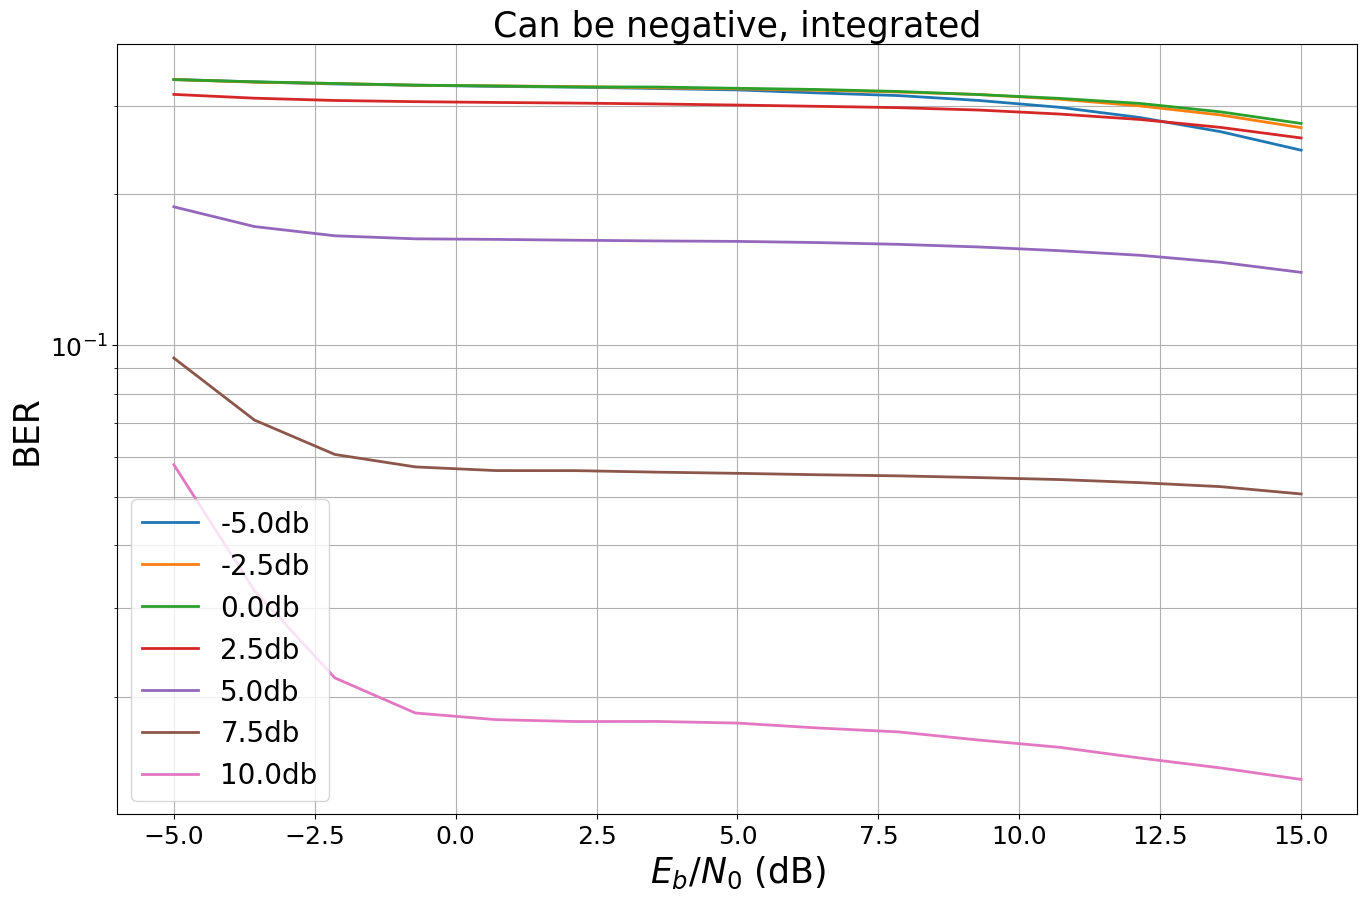

In [15]:
ber_plots.reset()
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128])
snrs = np.arange(-5, 10.5, 2.5, dtype=np.float32)
for ebno_db in snrs:
    jammer_parameters["training_constraint"] = MaxMeanSquareNorm(1.0)
    jammer_parameters["constraint_integrated"] = True
    filename = f"weights/{ebno_db:.1f}dB_relufix.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{ebno_db}db")
ber_plots.title = "Can be negative, integrated"
ber_plots()

We trained using the NonNegMaxSquareNorm constraint as variable-constraint instead of integrated into the network.

In [16]:
ber_plots.reset()
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128])
snrs = np.arange(-2.5, 10.5, 2.5, dtype=np.float32)
for ebno_db in snrs:
    jammer_parameters["training_constraint"] = NonNegMaxMeanSquareNorm(1.0)
    jammer_parameters["constraint_integrated"] = False
    filename = f"weights/{ebno_db}dB_constraint.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{ebno_db}db")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.2838e-01 | 1.0000e+00 |     1815803 |     5529600 |         2400 |        2400 |        19.0 |reached max iter       
   -3.571 | 3.2427e-01 | 1.0000e+00 |     1793072 |     5529600 |         2400 |        2400 |        12.3 |reached max iter       
   -2.143 | 3.2193e-01 | 1.0000e+00 |     1780163 |     5529600 |         2400 |        2400 |        12.0 |reached max iter       
   -0.714 | 3.1994e-01 | 1.0000e+00 |     1769131 |     5529600 |         2400 |        2400 |        12.0 |reached max iter       
    0.714 | 3.1876e-01 | 1.0000e+00 |     1762619 |     5529600 |         2400 |        2400 |        12.1 |reached max iter       
    2.143 | 3.1647e-01 | 1.0000e+00 |     1749925 |     5529600 |         2400 |     

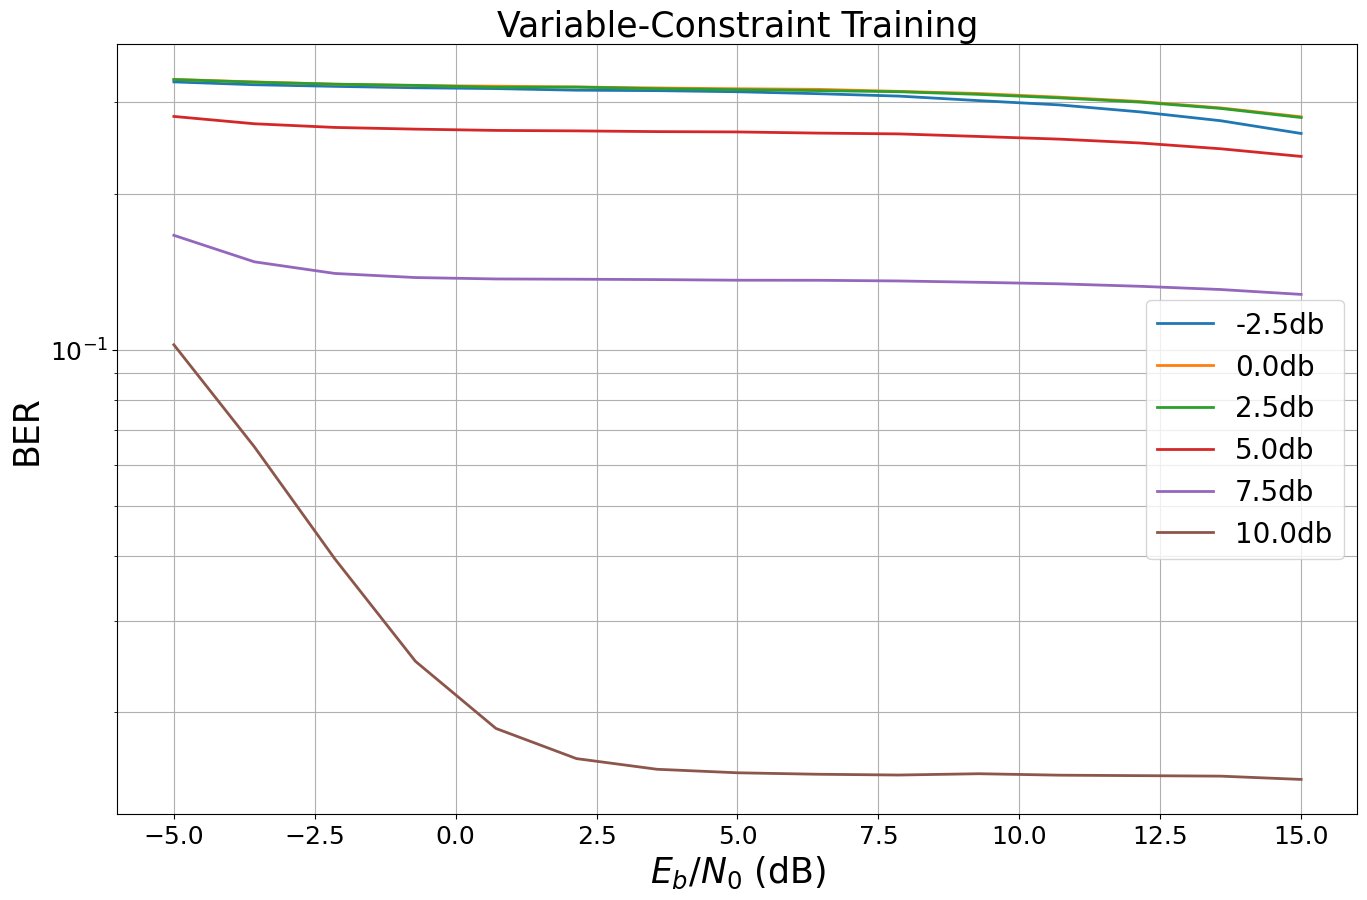

In [17]:
ber_plots.title = "Variable-Constraint Training"
ber_plots()

Comparison with variable-constraint, MaxMeanSquareNorm (can be negative)

In [ ]:
# TODO do we have to retrain? Not sure which weights
ber_plots.reset()
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 128])
snrs = np.arange(-2.5, 10.5, 2.5, dtype=np.float32)
for ebno_db in snrs:
    jammer_parameters["training_constraint"] = MaxMeanSquareNorm(1.0)
    jammer_parameters["constraint_integrated"] = False
    filename = f"weights/{ebno_db}dB_relufix_constraint.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, f"{ebno_db}db")